Imports

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Import and Format Data

In [38]:
root = './data/'
train_images_filepath = root + 'train-images-idx3-ubyte/train-images-idx3-ubyte'
train_labels_filepath = root + 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = root + 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = root + 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

def load_mnist_images(filepath):
    with open(filepath, 'rb') as f:
        raw_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return raw_images.reshape(raw_images.shape[0], -1) / 255.0

def load_mnist_labels(filepath):
    with open(filepath, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=8)

train_images = load_mnist_images(train_images_filepath)
train_labels = load_mnist_labels(train_labels_filepath)
test_images = load_mnist_images(test_images_filepath)
test_labels = load_mnist_labels(test_labels_filepath)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

n_train = int(0.8 * len(train_images))
train_set = TensorDataset(train_images_tensor[:n_train], train_labels_tensor[:n_train])
val_set = TensorDataset(train_images_tensor[n_train:], train_labels_tensor[n_train:])
test_set = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 512
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Create an MLP Class

In [39]:
# Model with BatchNorm
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256], output_size=10, dropout_rate=0.2):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = self.layers[-1](x)
        return x

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler(str(device))

Train the mlp

In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = torch.tensor(0.0, device=device)
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            with autocast(str(device)):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss * images.size(0)
        
        avg_train_loss = total_train_loss.item() / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = torch.tensor(0.0, device=device)
        with torch.no_grad():
            for images, labels in val_loader:
                with autocast(str(device)):
                    outputs = model(images)
                    total_val_loss += criterion(outputs, labels) * images.size(0)
        
        avg_val_loss = total_val_loss.item() / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

Evaluate model

In [41]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            with autocast(str(device)):
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test accuracy: {accuracy:.4f}")
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Run

Epoch 0/100 - Train Loss: 0.3544, Val Loss: 0.1341
Epoch 10/100 - Train Loss: 0.0185, Val Loss: 0.0727
Early stopping at epoch 17


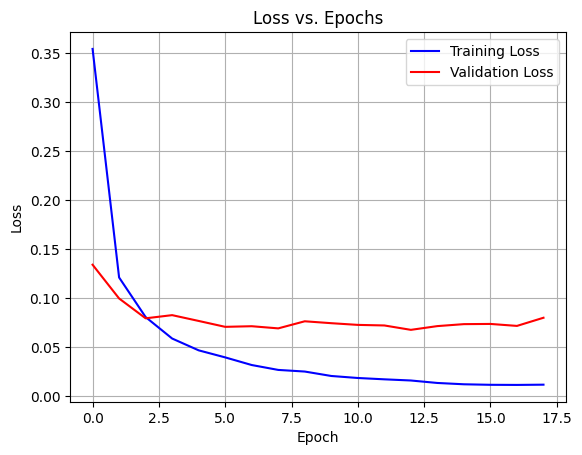

Test accuracy: 0.9819


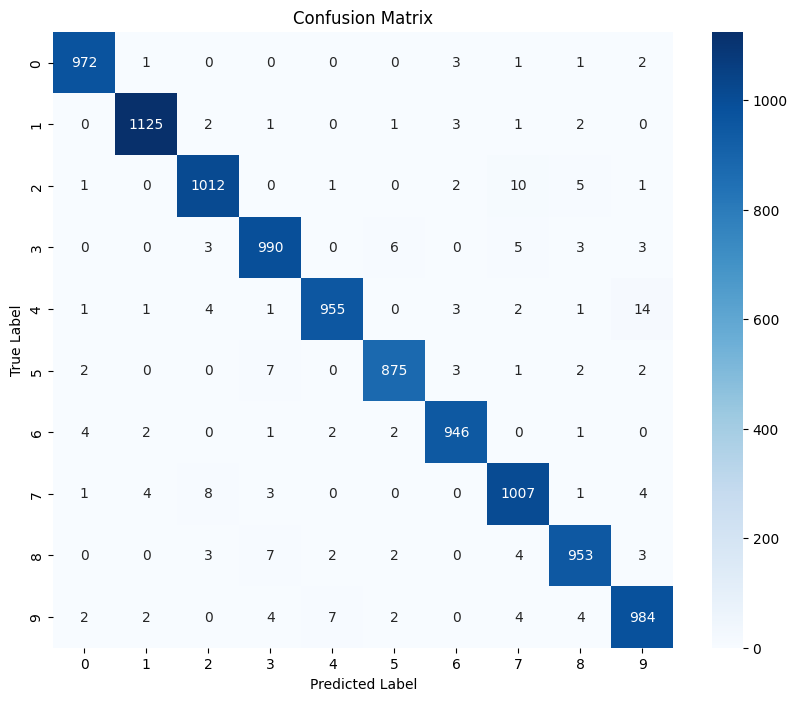

In [42]:
train_model(model, train_loader, val_loader, criterion, optimizer)
evaluate_model(model, test_loader)